# IPCC OpenAI ChatBot

 Introducing our IPCC Chat Bot! 🌍 Your climate companion, powered by the UN-backed IPCC. Decode the latest on global warming, get quick answers, and stay in the loop with fresh climate studies. Let's make understanding climate change a breeze! 🌱🤖 #ClimateSmartBot

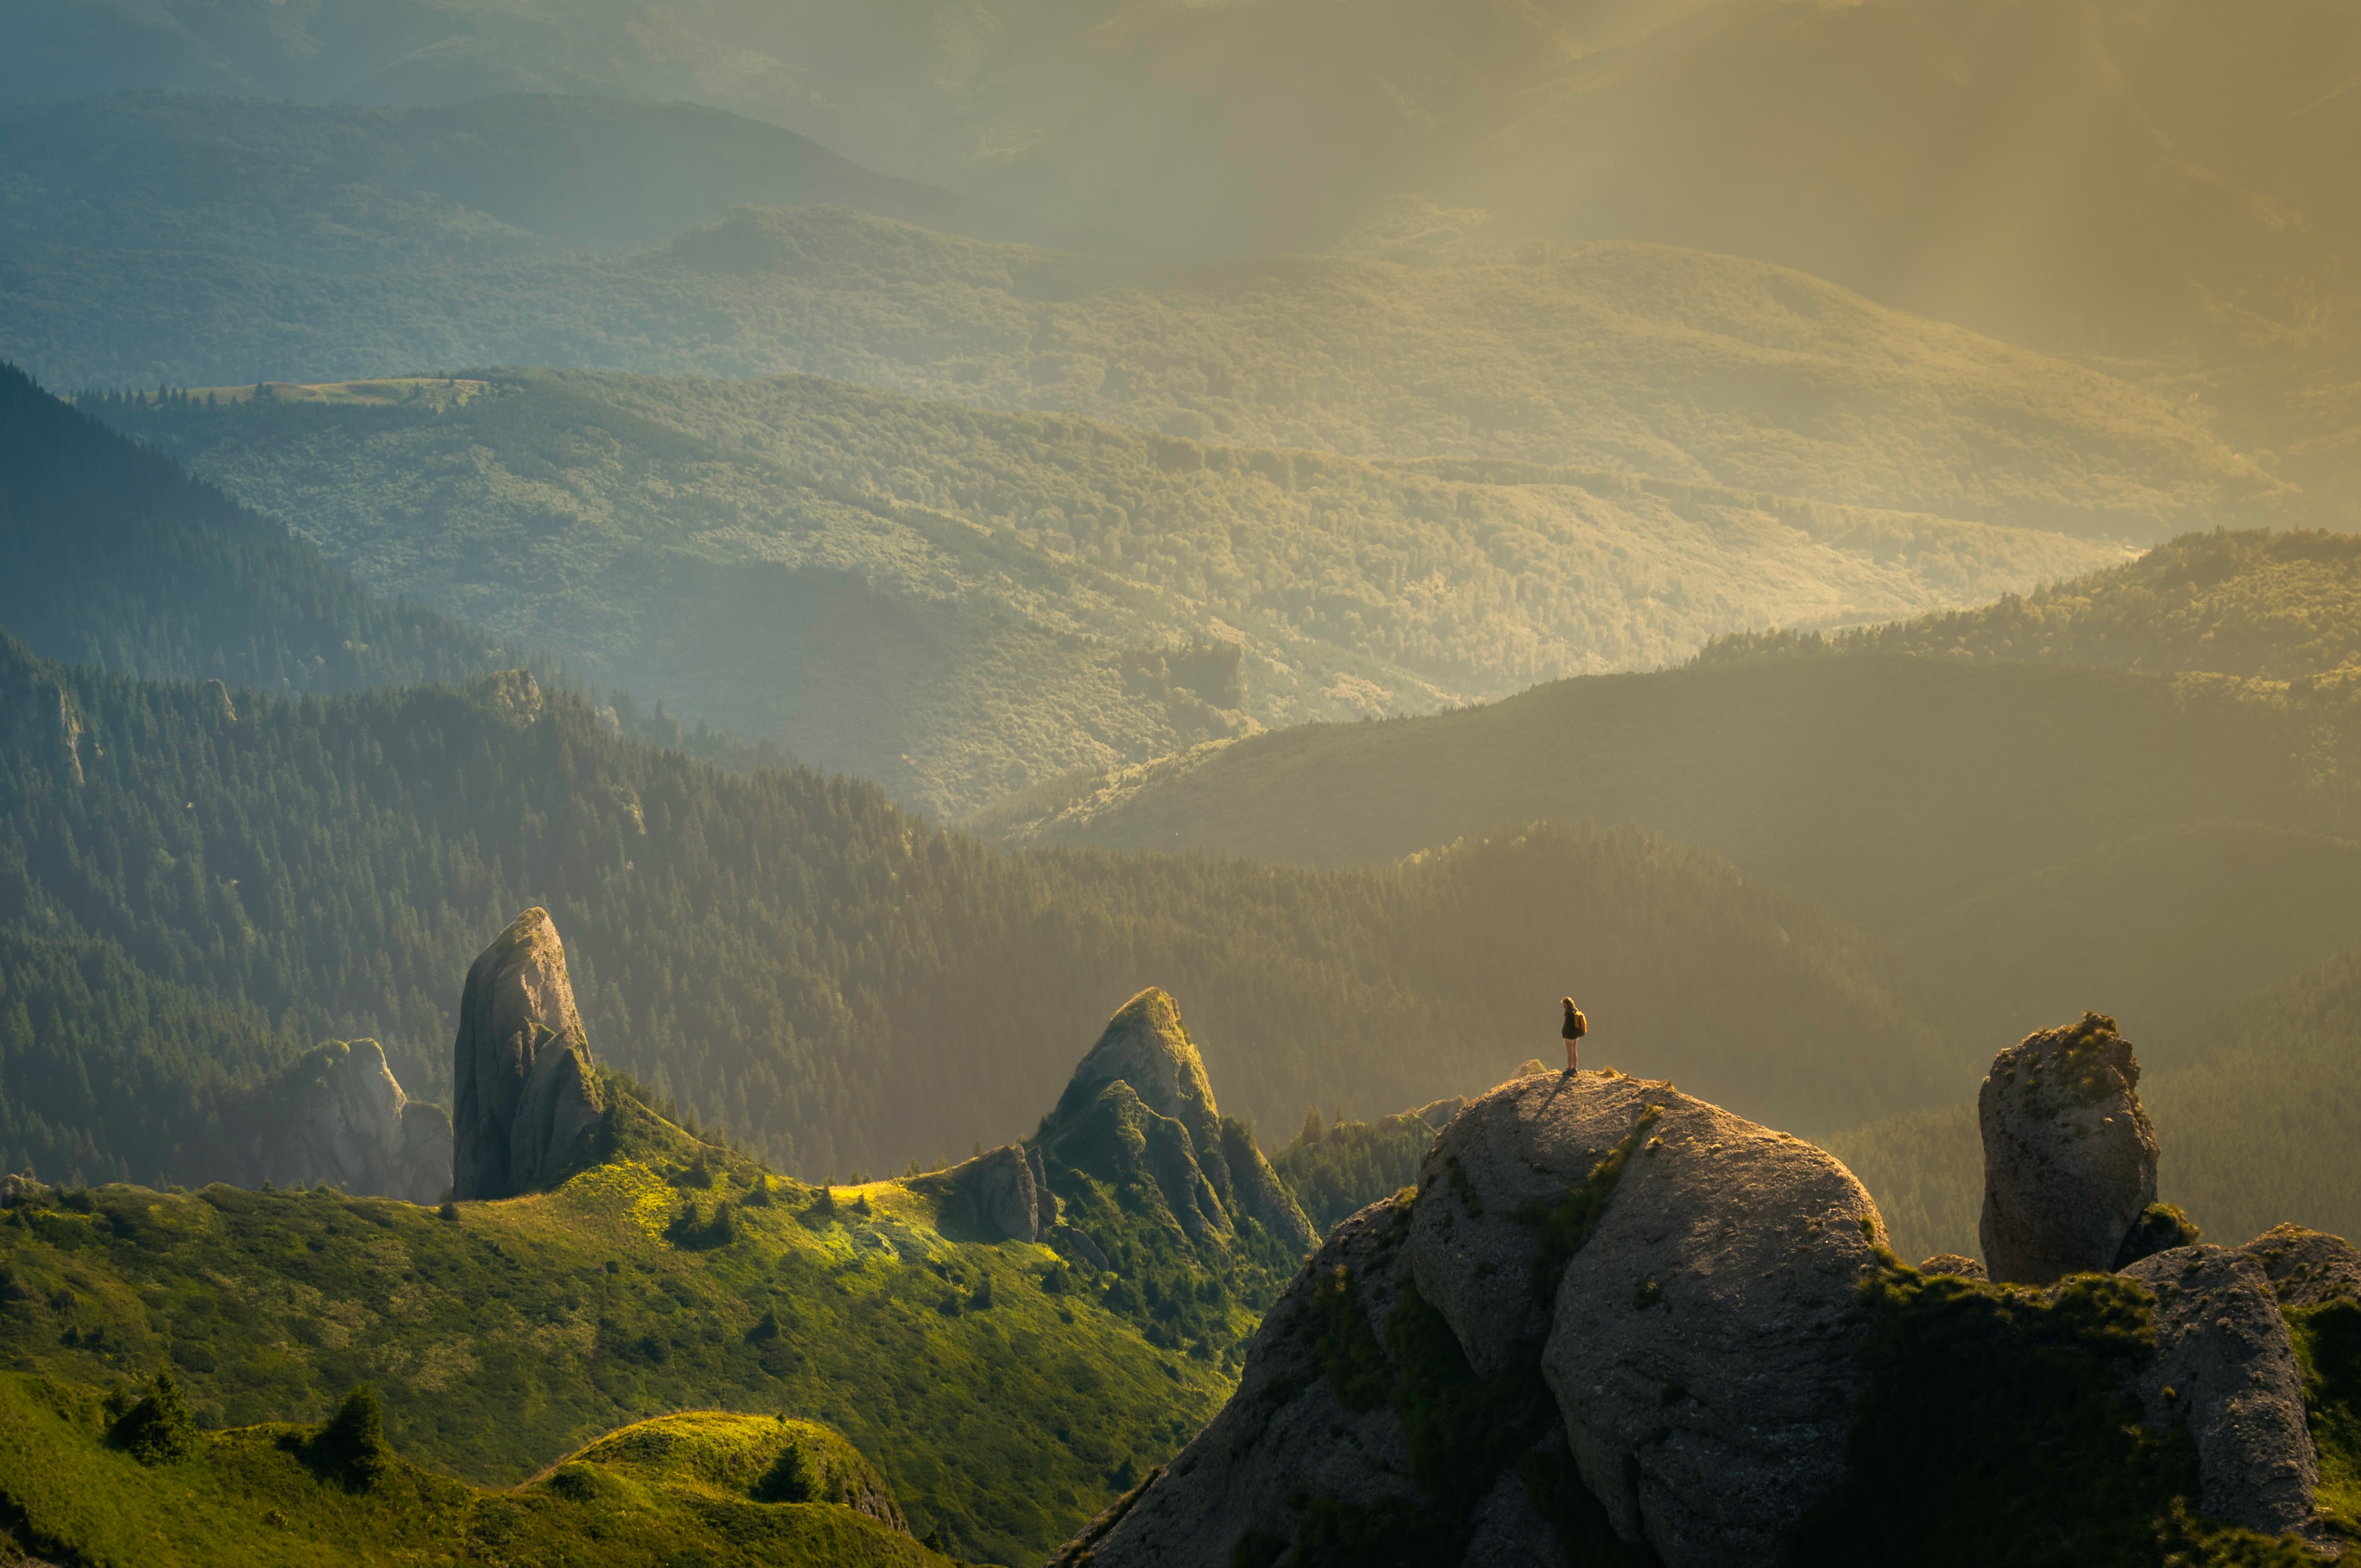




# Table of Content

- What is IPCC ?
- Mission
- Challenge Overview
- Strategy
- Implementation
  - Indexing
  - RAG Pipeline
  - Try It

## What is IPCC ?
 The Intergovernmental Panel on Climate Change (IPCC) is a United Nations body established in 1988. Its primary mission is to assess scientific information related to climate change, its impacts, and potential adaptation and mitigation strategies. The IPCC does not conduct original research but synthesizes and reviews existing scientific literature.

The organization is organized into three working groups:

- Working Group I (WGI): Focuses on the physical science basis of climate change, examining factors such as greenhouse gas concentrations, temperature trends, and atmospheric dynamics.

- Working Group II (WGII): Examines impacts, vulnerability, and adaptation related to climate change, assessing how changes in the climate affect ecosystems, societies, and economies.

- Working Group III (WGIII): Concentrates on mitigation strategies, evaluating options for reducing greenhouse gas emissions and promoting sustainable development practices.

The IPCC produces Assessment Reports at regular intervals, summarizing the state of climate science and offering policymakers and the public valuable information for addressing climate-related challenges. The reports are widely regarded as authoritative references in the field, contributing significantly to global climate policy discussions.

## Mission

The purpose of this chatbot providing question answering on IPCC reports is to enhance accessibility and understanding of complex climate change information. This chatbot serves several key purposes:
  - Instant Access to Information
  - Democratizing Knowledge
  - Promoting Awareness
  - Efficient Learning
  - Supporting Decision-Making

Based on latest IPCC reports (https://www.ipcc.ch/reports/), the IPCC chatbot will be able to answer any questions on state-of-the art studies about climate change. Powered by Langchain framework, OpenAI GPT-3-Turbo model, and Huggingface Embeddings, this chatbot will be able to maintain resourceful conversations on climate change.

## Overview

Currently LLMs suffer from several drawbacks:
- They are black boxes and we don't know exactly which data soources were used for their training. Hallucination (generation of fake data due to a lack of knowledge that looks like authentic) may certainly occur for our specific task.
- They miss up-to-date information and fine-tuning end-to-end on new data these billion parameters monsters is not our best option
- Producing a new domain-specific LLM is a costly and time consuming task

We will then use RAG method to solve these weeknesses.

**Retrieval Augmented Generation (RAG)** means fetching up-to-date or context-specific data from an external database and making it available to an LLM when asking it to generate a response, solving this problem. You can store proprietary business data or information about the world and have your application fetch it for the LLM at generation time, reducing the likelihood of hallucinations. The result is a noticeable boost in the performance and accuracy of your GenAI application.


## Strategy

LangChain has a number of components designed to help build question-answering applications. We’ll build a simple Q&A application over a text data source, a typical RAG application. This is based on two main components : **Indexing** and **Retrieval Augmented Generation**

**Indexing**: a pipeline for ingesting data from a source and indexing it. This usually happen offline. (Load - Split - Store)

<img src='https://python.langchain.com/assets/images/rag_indexing-8160f90a90a33253d0154659cf7d453f.png'>

**Retrieval and generation**: the actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model. Given a user input, relevant splits are retrieved from storage using a Retriever. A ChatModel / LLM produces an answer using a prompt that includes the question and the retrieved data

<img src='https://python.langchain.com/assets/images/rag_retrieval_generation-1046a4668d6bb08786ef73c56d4f228a.png'>


More info can be found here : [Langchain Documentation](https://python.langchain.com/docs/use_cases/question_answering/ )



## Implementation

In [1]:
# Install packages

!pip install -U tiktoken cohere langchain openai chromadb langchainhub bs4 pypdf sentence_transformers

In [2]:
# Define OpenAI Api key
# Api Keys can be created at https://platform.openai.com/ (you will to provision your account to use GPT models online)

import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()

··········


In [3]:
# Import necessary libraries

import bs4
from langchain import hub
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import WebBaseLoader
from langchain.document_loaders import PyPDFDirectoryLoader

from langchain.embeddings import OpenAIEmbeddings
from langchain.schema import StrOutputParser
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain_core.runnables import RunnablePassthrough



In [4]:
# Connect google colab notebooks to Google drive directories
# Access IPCC reports (can be dowloaded at https://www.ipcc.ch/reports/)
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
pdf_folder_path = f'{root_dir}/Colab Data/IPCC'
print(os.listdir(pdf_folder_path))

Mounted at /content/gdrive
['IPCC_AR6_SYR_FullVolume.pdf', 'IPCC_AR6_WGIII_FullReport.pdf', 'IPCC_AR6_WGI_FullReport_small.pdf', 'IPCC_AR6_WGII_FullReport.pdf', '.DS_Store', 'IPCC_Store']


### Indexing : Load-Transform-Store PDF documents


<img src='https://miro.medium.com/v2/resize:fit:1400/format:webp/1*FWwgOvUE660a04zoQplS7A.png'>


In [5]:
# Load data with PyPDF library from a directory
from langchain.embeddings import HuggingFaceBgeEmbeddings


try :
  # load from disk
  ipcc_store = Chroma(persist_directory=pdf_folder_path+'/IPCC_Store', embedding_function=HuggingFaceBgeEmbeddings())
  retriever = ipcc_store.as_retriever()

except :
  # build vector store from directory

  #Load documents
  loader = PyPDFDirectoryLoader(pdf_folder_path)

  docs = loader.load()

  # Split Documents
  text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
  splits = text_splitter.split_documents(docs)

  # Embed splits with Hugging Face Embeddings.
  embedding = HuggingFaceBgeEmbeddings()

  vectorstore = Chroma.from_documents(documents=splits, embedding=embedding,persist_directory=pdf_folder_path+'/IPCC_Store')
  vectorstore.persist()

# Function joining retrieved documents from vector store based on human query
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


## RAG pipeline

Once done with Indexing, we are able to merge user question with contextualized documentation. These 2 elements are then fed to a prompt instructing an LLM to answer User question based on the extra knowledge provided in the retrieved document chunks.





<img src='https://miro.medium.com/v2/resize:fit:1400/format:webp/1*leoW-Pn0ohWalrUBbzdidA.png'>

Additionally to this pipeline, we would like to enable the bot to maintain a conversation with the user with the help of a chat history.
Every time the user will ask a new question, the chatbot will look at previous interactions before answering. How is it done? Before adding any context to the QA prompt, the LLM will be used to reformulate the latest user question with the help of the chat history. The chat history consists on a succession of Human-AI messages pairs. The reformulated question is then used to generate context via document retrieval. Finally Context + Reformulated question are fed via the QA prompt to the LLM to give an answer.

<img src='https://blog.langchain.dev/content/images/2023/01/screen-shot-2023-01-16-at-10.26.04-pm.png'>

In [6]:

# Instantiate LLM Model : GPT 3.5-Turbo
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


In [7]:
# Create contextualized chain that transform input prompt with chat history
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

contextualize_q_system_prompt = """Given a chat history and the latest user question \
which might reference context in the chat history, formulate a standalone question \
which can be understood without the chat history. Do NOT answer the question, \
just reformulate it if needed and otherwise return it as is."""
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder(variable_name="chat_history"),
        ("human", "{question}"),
    ]
)
contextualize_q_chain = contextualize_q_prompt | llm | StrOutputParser()

In [8]:
# Test contextualized prompt

from langchain_core.messages import AIMessage, HumanMessage

contextualize_q_chain.invoke(
    {
        "chat_history": [
            HumanMessage(content="What does LLM stand for?"),
            AIMessage(content="Large language model"),
        ],
        "question": "What is meant by large",
    }
)



'What is the definition of "large" in the context of a language model?'

In [9]:
qa_system_prompt = """You are an assistant for question-answering tasks.\
                Use the following pieces of retrieved context to answer the question.\
                If you don't know the answer, just say that you don't know.\
                Use 20 sentences maximum and keep the answer concise.\n\
                {context}"""

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", qa_system_prompt),
        MessagesPlaceholder(variable_name="chat_history"),
        ("human", "{question}"),
    ]
)


def contextualized_question(input: dict):
    if input.get("chat_history"):
        return contextualize_q_chain
    else:
        return input["question"]

In [10]:

# Pipe Components
rag_chain = (
    RunnablePassthrough.assign(
        context=contextualized_question | retriever | format_docs
    )
    | qa_prompt
    | llm
)


# Note : we removed StrOutputParser because we want to feed chat history with
# AIMessage objects not strings

## Try it

In [11]:
chat_history = []

question = "How human impact global warming?"
ai_msg = rag_chain.invoke({"question": question, "chat_history": chat_history})
chat_history.extend([HumanMessage(content=question), ai_msg])

In [12]:
ai_msg.content

"Human activities contribute to global warming primarily through the release of greenhouse gases into the atmosphere. The burning of fossil fuels, such as coal, oil, and natural gas, for energy production and transportation is a major source of greenhouse gas emissions. Deforestation, particularly in tropical regions, also contributes to global warming as trees absorb carbon dioxide and their removal reduces the planet's capacity to absorb this greenhouse gas. Additionally, agricultural practices, such as livestock farming and the use of synthetic fertilizers, release methane and nitrous oxide, which are potent greenhouse gases. These human-induced emissions trap heat in the atmosphere, leading to an increase in global temperatures and climate change."

In [13]:
question = "Do you know other impacts not mentioned previously ? "
ai_msg = rag_chain.invoke({"question": question, "chat_history": chat_history})
chat_history.extend([HumanMessage(content=question), ai_msg])

In [14]:
import textwrap
# Set the maximum number of characters per line
max_length = 80

# Split the text into lines
lines = ai_msg.content.split('\n')

# Wrap each line
wrapped_lines = []
for line in lines:
  if line.strip() != '':
      wrapped_line = textwrap.wrap(line, max_length, break_long_words=False, replace_whitespace=False)
      wrapped_lines.extend(wrapped_line)

# Join the wrapped lines with a newline character
formatted_text = '\n'.join(wrapped_lines)

print(formatted_text)

Yes, there are several other impacts of human activities on global warming that
were not mentioned previously. These include:
1. Ocean acidification: Increased carbon dioxide emissions from human activities
are absorbed by the oceans, leading to a decrease in pH levels and making the
water more acidic. This can have detrimental effects on marine ecosystems,
including coral reefs and shellfish.
2. Sea-level rise: Global warming causes the melting of glaciers and ice caps,
leading to an increase in sea levels. This poses a significant threat to coastal
communities and ecosystems, as well as increasing the risk of flooding and
erosion.
3. Extreme weather events: Human-induced climate change is associated with an
increase in the frequency and intensity of extreme weather events such as
hurricanes, heatwaves, droughts, and heavy rainfall. These events can have
devastating impacts on communities, infrastructure, and agriculture.
4. Disruption of ecosystems: Changes in temperature and precipi

In [15]:
question = "Explain how human activities impact global warming? and which activities?"
question = "Explain IPCC scenarios. How are they defined ?"
question = "Can you give a proof of human responsability in global warming against climato-negationist arguments?"

# Power ahead !